# Boosting Trees

# Preamble

In [ ]:
# Common imports
import numpy as np # numpy is THE toolbox for scientific computing with python
import pandas as pd # pandas provides THE data structure and data analysis tools for data scientists 

# maximum number of columns
pd.set_option("display.max_rows", 101)
pd.set_option("display.max_columns", 101)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from warnings import filterwarnings
filterwarnings('ignore')

# Introduction

Let us quickly refresh our knowledge on ensemble methods: Many weak learns give a strong learner. A common choice for weak learners are decision trees. An ensemble model with decision trees as the underlying base learner is called Random Forest.

Ensemble methods have several advantages. Two of the most important advantages are:

*    Random forests do not have assumptions as, for instance, linear models have. They are **non-parametric models**.
*    As for linear models we can understand the importance of features.

Boosting is a special version of combining weak learners into a strong learner. The predictors are trained **sequentially**, each trying to correct the predictions of the previous one. Therefore the **weak learners are not independent of each other.**

Most important are **AdaBoost** and **GradientBoosting**.

Here is a pictoral representation of this general general idea:

![](boosting_idea.png)

**Gradient boosted trees** are frequently the winning entries in machine learning competitions,
and are widely used in industry. They are generally a bit more sensitive to
parameter settings than random forests, but can provide better accuracy if the parameters
are set correctly.

As both gradient boosting and random forests perform well on similar kinds of data,
a common approach is to first try random forests, which work quite robustly. If random
forests work well but prediction time is at a premium, or it is important to
squeeze out the last percentage of accuracy from the machine learning model, moving
to gradient boosting often helps.

If you want to apply gradient boosting to a large-scale problem, it might be worth
looking into the xgboost package and its Python interface.

# Building our own Gradient Boosting Regressor

In Gradient Boosting we fit the new predictor to tue residual errors made by the previous predictor.

In [2]:
# A noisy quadratic training set:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

We train our first decision tree:

In [3]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

We then train a second decision tree on the resiual errors of the first decision tree:

In [4]:
y2 = y - tree_reg1.predict(X) # observation - prediction
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

We train a third decision tree on the residual errors of the second decision tree:

In [5]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

On the left-hand side you see the predictions of the three trees. The ensemble's prediction is on the right column. In the second row you see that a tree is trained on the residual errors of the first tree. 

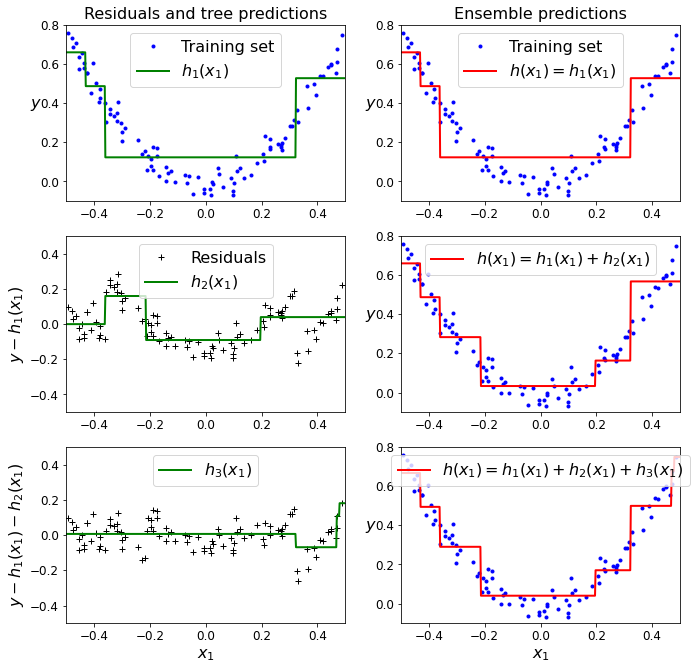

In [6]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

One can see how the trees gradually improve.

Let us now add the predictions for all trees to give a final prediction

In [11]:
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.75026781])

Scikit learn's GradientBosstingRegressor gives the same result:

In [12]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [13]:
gbrt.predict(X_new)

array([0.75026781])

# Hyperparameters 

*    *n_estimators* is the number of trees

*    *learning_rate* scales the contribution of each tree. With a small value one will need more trees in the ensemble to fit the training set, but it usually generalizes better. This is a regularization technique called *shrinkage*. 

In [14]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Here we compare a gradient boosting algorithm with a large learning rate, but only small number of predictors with a boosting algorithm with a small learning rate but a large number of estimators.

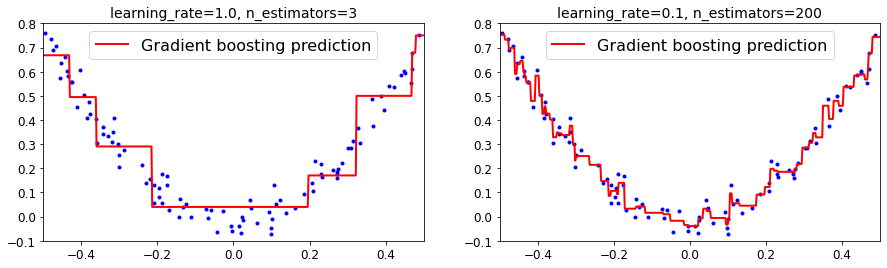

In [17]:
plt.figure(figsize=(15,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Gradient boosting prediction")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Gradient boosting prediction")
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

plt.show()

The GradientBoostingRegressor class also supports a **subsample hyperparameter**,
which specifies the fraction of training instances to be used for training each tree. For
example, if subsample=0.25, then each tree is trained on 25% of the training instances,
selected randomly. As you can probably guess by now, this technique trades a
higher bias for a lower variance. It also speeds up training considerably. This is called
Stochastic Gradient Boosting.

# Early Stopping

In [18]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=56,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

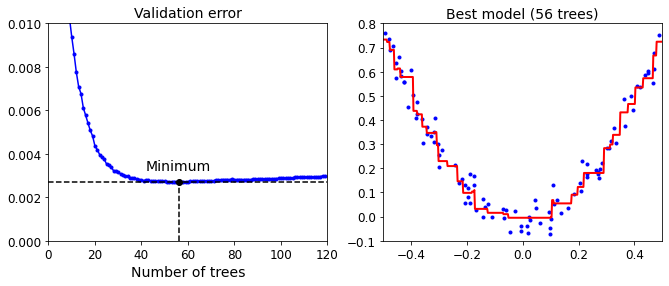

In [21]:
min_error = np.min(errors)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)

plt.show()

# XGBoost

*XGBoost = Extreme Gradient Boosting*

*Here are the docs: https://xgboost.readthedocs.io/en/latest/python/index.html.* 

*It is heavily used in industry and should be in every data scientist's toolsbox. It is not within Scikit-Learn, but works quite similar to Scikit-Learn's API.*

In [22]:
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=120,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [25]:
if xgboost is not None:  
    xgb_reg = xgboost.XGBRegressor(random_state=42, verbosity = 0)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    print("Validation MSE:", val_error)

Validation MSE: 0.0028512559726563943


In [26]:
if xgboost is not None: 
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    print("Validation MSE:", val_error)

[0]	validation_0-rmse:0.286719
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.258221
[2]	validation_0-rmse:0.232634
[3]	validation_0-rmse:0.210526
[4]	validation_0-rmse:0.190232
[5]	validation_0-rmse:0.172196
[6]	validation_0-rmse:0.156394
[7]	validation_0-rmse:0.142241
[8]	validation_0-rmse:0.129789
[9]	validation_0-rmse:0.118752
[10]	validation_0-rmse:0.108388
[11]	validation_0-rmse:0.100155
[12]	validation_0-rmse:0.09208
[13]	validation_0-rmse:0.084791
[14]	validation_0-rmse:0.078699
[15]	validation_0-rmse:0.073248
[16]	validation_0-rmse:0.069391
[17]	validation_0-rmse:0.066277
[18]	validation_0-rmse:0.063458
[19]	validation_0-rmse:0.060326
[20]	validation_0-rmse:0.0578
[21]	validation_0-rmse:0.055643
[22]	validation_0-rmse:0.053943
[23]	validation_0-rmse:0.053138
[24]	validation_0-rmse:0.052415
[25]	validation_0-rmse:0.051821
[26]	validation_0-rmse:0.051226
[27]	validation_0-rmse:0.051135
[28]	validation_0-rmse:0.05091
[29]	validation_0-rmse

Look at the difference in execution time between XGBoost and scikit-learn's GradientBoosting API:

In [28]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%timeit xgboost.XGBRegressor(verbosity = 0).fit(X_train, y_train) if xgboost is not None else None

5.39 ms ± 98.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [29]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

18.7 ms ± 286 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# (Advanced Topic) Hyperparameter Search with XGBoost 

In [30]:
import yaml
# load configuration file
with open('config.yml', 'r') as file:
    config = yaml.safe_load(file)

In [31]:
config

{'learning_rate': [0.1],
 'n_estimators': [100, 200],
 'max_depth': [5, 6, 7, 8],
 'min_child_weight': [2, 3, 4, 5, 6],
 'gamma': [0],
 'subsample': [0.8, 0.9, 1.0],
 'colsample_bytree': [0.8, 0.9, 1.0],
 'nthread': [-1],
 'scale_pos_weight': [1],
 'seed': [42]}

In [32]:
config['learning_rate']

[0.1]

In [33]:
configurations = []
for a in config['learning_rate']:
    for b in config['n_estimators']:
        for c in config['max_depth']:
            for d in config['min_child_weight']:
                for e in config['gamma']:
                    for f in config['subsample']:
                        for g in config['colsample_bytree']:
                            for h in config['nthread']:
                                for i in config['scale_pos_weight']:
                                    for j in config['seed']:
                                        param = {'learning_rate'    : a,
                                                'n_estimators'     : b,
                                                'max_depth'        : c,
                                                'min_child_weight' : d,
                                                'gamma'            : e,
                                                'subsample'        : f,
                                                'colsample_bytree' : g,
                                                'nthread'          : h,
                                                'scale_pos_weight' : i,
                                                'seed'             : j,
                                                'objective'        : 'reg:squarederror'}
                                        configurations.append(param)

print('Size of configuration space : ', len(configurations))

Size of configuration space :  360


In [34]:
config = configurations[0]
print(config)

{'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 5, 'min_child_weight': 2, 'gamma': 0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'nthread': -1, 'scale_pos_weight': 1, 'seed': 42, 'objective': 'reg:squarederror'}


In [38]:
model = xgboost.XGBRegressor(
    learning_rate    = config['learning_rate'],
    n_estimators     = config['n_estimators'], # set it to high value = 500
    max_depth        = config['max_depth'], # max_depth = 6,7...,13,14 - 20
    min_child_weight = config['min_child_weight'], # prevent overfitting
    gamma            = config['gamma'],
    subsample        = config['subsample'],
    colsample_bytree = config['colsample_bytree'],
    nthread          = config['nthread'], # number of cores = -1
    scale_pos_weight = config['scale_pos_weight'],
    seed             = config['seed'],
    verbosity=0
)

In [39]:
model.fit(X_train, y_train,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=50,
            eval_metric = 'rmse',
            verbose=False
         )

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=2, missing=None, n_estimators=100,
             n_jobs=1, nthread=-1, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             silent=None, subsample=0.8, verbosity=0)

In [40]:
# Eval model
y_pred_trn = model.predict(X_train)
y_pred_val = model.predict(X_val)
trn_err    = np.sqrt(mean_squared_error(y_train, y_pred_trn))
val_err    = np.sqrt(mean_squared_error(y_val, y_pred_val))

print(trn_err)
print(val_err)

0.03658531146264678
0.04792059842848981


# LightGMB

A couple of years ago, Microsoft announced its gradient boosting framework LightGBM. Nowadays, it steals the spotlight in gradient boosting machines. Kagglers start to use LightGBM more than XGBoost. **LightGBM is 6 times faster than XGBoost.**

The size of datasets is increasing rapidly. It is become very difficult for traditional data science algorithms to give accurate results. Light GBM is prefixed as Light because of its high speed. Light GBM can handle the large size of data and takes lower memory to run.

LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

*    Faster training speed and higher efficiency.

*    Lower memory usage.

*    Better accuracy.

*    Support of parallel and GPU learning.

*    Capable of handling large-scale data.

More information in this nice kaggle notebook: https://www.kaggle.com/prashant111/lightgbm-classifier-in-python.

Also going through the docs is helpful: https://lightgbm.readthedocs.io/en/latest/#.

In [41]:
import lightgbm as lgb

The LightGBM Python module can load data from:

*    LibSVM (zero-based) / TSV / CSV / TXT format file

*    NumPy 2D array(s), pandas DataFrame, H2O DataTable’s Frame, SciPy sparse matrix

*    LightGBM binary file

*    LightGBM Sequence object(s)

The data is stored in a `Dataset` object.

## First Example

In [42]:
# load and preview data
df = pd.read_csv('Breast_cancer_data.csv')
df.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0


In [43]:
X = df[['mean_radius','mean_texture','mean_perimeter','mean_area','mean_smoothness']]
y = df['diagnosis']

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [45]:
# build the lightgbm model
import lightgbm as lgb
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [46]:
# predict the results
y_pred=clf.predict(X_test)

In [47]:
# view accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.9240


In [48]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(clf.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(clf.score(X_test, y_test)))

Training set score: 1.0000
Test set score: 0.9240


# CatBoost

Should be very good when many categorical features are at hand.

Read the docs: https://catboost.ai/docs/

## Classification Example

In [52]:
import numpy as np
from catboost import CatBoostClassifier, Pool

# initialize data
train_data = np.random.randint(0,
                               100, 
                               size=(100, 10))

train_labels = np.random.randint(0,
                                 2,
                                 size=(100))

test_data = catboost_pool = Pool(train_data, 
                                 train_labels)

model = CatBoostClassifier(iterations=2,
                           depth=2,
                           learning_rate=1,
                           loss_function='Logloss',
                           verbose=True)
# train the model
model.fit(train_data, train_labels)
# make the prediction using the resulting model
preds_class = model.predict(test_data)
preds_proba = model.predict_proba(test_data)
print("class = ", preds_class)
print("proba = ", preds_proba)

0:	learn: 0.6753916	total: 75.4ms	remaining: 75.4ms
1:	learn: 0.6408962	total: 76ms	remaining: 0us
class =  [0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0
 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
proba =  [[0.61011136 0.38988864]
 [0.53885985 0.46114015]
 [0.53885985 0.46114015]
 [0.444218   0.555782  ]
 [0.61011136 0.38988864]
 [0.3782958  0.6217042 ]
 [0.65855661 0.34144339]
 [0.3782958  0.6217042 ]
 [0.59460279 0.40539721]
 [0.59460279 0.40539721]
 [0.59460279 0.40539721]
 [0.61011136 0.38988864]
 [0.59460279 0.40539721]
 [0.59460279 0.40539721]
 [0.3782958  0.6217042 ]
 [0.53885985 0.46114015]
 [0.65830583 0.34169417]
 [0.59460279 0.40539721]
 [0.59460279 0.40539721]
 [0.61011136 0.38988864]
 [0.3782958  0.6217042 ]
 [0.65830583 0.34169417]
 [0.61011136 0.38988864]
 [0.59460279 0.40539721]
 [0.59460279 0.40539721]
 [0.55490461 0.44509539]
 [0.55490461 0.44509539]
 [0.

## Regression Example

In [53]:
import numpy as np
from catboost import Pool, CatBoostRegressor
# initialize data
train_data = np.random.randint(0, 
                               100, 
                               size=(100, 10))
train_label = np.random.randint(0, 
                                1000, 
                                size=(100))
test_data = np.random.randint(0, 
                              100, 
                              size=(50, 10))
# initialize Pool
train_pool = Pool(train_data, 
                  train_label, 
                  cat_features=[0,2,5])
test_pool = Pool(test_data, 
                 cat_features=[0,2,5]) 

# specify the training parameters 
model = CatBoostRegressor(iterations=2, 
                          depth=2, 
                          learning_rate=1, 
                          loss_function='RMSE')
#train the model
model.fit(train_pool)
# make the prediction using the resulting model
preds = model.predict(test_pool)
print(preds)

0:	learn: 269.9275155	total: 10.5ms	remaining: 10.5ms
1:	learn: 267.2722544	total: 19.8ms	remaining: 0us
[449.20041023 593.16170923 593.16170923 449.20041023 449.20041023
 536.99880777 393.03750876 393.03750876 593.16170923 593.16170923
 449.20041023 393.03750876 593.16170923 393.03750876 449.20041023
 593.16170923 449.20041023 536.99880777 393.03750876 460.62568547
 393.03750876 449.20041023 393.03750876 593.16170923 449.20041023
 593.16170923 449.20041023 449.20041023 449.20041023 449.20041023
 611.12984858 536.99880777 680.67986172 449.20041023 449.20041023
 680.67986172 536.99880777 662.71172237 449.20041023 536.99880777
 449.20041023 449.20041023 449.20041023 393.03750876 449.20041023
 393.03750876 536.99880777 449.20041023 518.75042337 449.20041023]


# Stacking & Blending

The last ensemble method we will discuss in this Jupyter notebook is called **stacking** (short for
stacked generalization).

It is based on a simple idea: instead of using trivial functions
(such as hard voting) to aggregate the predictions of all predictors in an ensemble,
we train a model to perform this aggregation. This final predictor is called a **blender**.

To train a blender, a common approach is to use a hold-out set.

In [54]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1)
    mnist.target = mnist.target.astype(np.int64)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

In [55]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [56]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    mnist.data, mnist.target, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

In [57]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

In [58]:
random_forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
extra_trees_clf   = ExtraTreesClassifier(n_estimators=10, random_state=42)
svm_clf           = LinearSVC(random_state=42)
mlp_clf           = MLPClassifier(random_state=42)

In [59]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

Training the RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Training the ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
      

## Use a voting classifier

In [60]:
[estimator.score(X_val, y_val) for estimator in estimators]

[0.9469, 0.9492, 0.8626, 0.9655]

In [61]:
from sklearn.ensemble import VotingClassifier

In [62]:
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]

In [63]:
voting_clf = VotingClassifier(named_estimators)

In [64]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_lea

In [65]:
voting_clf.score(X_val, y_val)

0.9614

In [66]:
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

[0.9469, 0.9492, 0.8626, 0.9655]

In [67]:
voting_clf.set_params(svm_clf=None)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_lea

In [68]:
voting_clf.estimators

[('random_forest_clf',
  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                         criterion='gini', max_depth=None, max_features='auto',
                         max_leaf_nodes=None, max_samples=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, n_estimators=10,
                         n_jobs=None, oob_score=False, random_state=42, verbose=0,
                         warm_start=False)),
 ('extra_trees_clf',
  ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fractio

## Stacking

In [69]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [70]:
X_val_predictions

array([[5., 5., 5., 5.],
       [8., 8., 8., 8.],
       [2., 2., 2., 2.],
       ...,
       [7., 7., 7., 7.],
       [6., 6., 6., 6.],
       [7., 7., 7., 7.]], dtype=float32)

In [71]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [72]:
rnd_forest_blender.oob_score_

0.9608

You could fine-tune this blender or try other types of blenders (e.g., an `MLPClassifier`), then select the best one using cross-validation, as always.

We have just trained a blender, and together with the classifiers they form a stacking ensemble! Now let's evaluate the ensemble on the test set. For each image in the test set, make predictions with all your classifiers, then feed the predictions to the blender to get the ensemble's predictions. How does it compare to the voting classifier we trained earlier?

In [74]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [75]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [76]:
from sklearn.metrics import accuracy_score

In [77]:
accuracy_score(y_test, y_pred)

0.96

This stacking ensemble does not perform as well as the soft voting classifier we trained earlier, it's just as good as the best individual classifier.